# Mask/Non mask Deep learning system


**Inroduction:** We are going to classify two classes by applying concept of transfer learning on a pretrained model. The binary classification dataset we have considered for this assignment is **'mask'** and **'non-mask'** considering the current covid scenario.

## Part 1: About Dataset

**Classses:** We have two classes which will be classified using our deep learning model. The two classes are **'mask'** and **'non-mask'**.

**Dataset Creation:** Images were scrapped from sources like www.google.com, www.shutterstock.com using Image Downloader Extension of google chrome which helps in downloading bulk images from any website also images were used from  section of images from dataset compiled by Chandrika Deb (https://github.com/chandrikadeb7/) .The scrapped data still contained some images which were not appropriate for our required dataset so we manually removed any image which were not a good fit. Resultant dataset has been splitted into test and training dataset.

**Test/Train split ratio:**Exact sizes for test dataset includes 151 images for masked and non-masked individually and for training we used 604 images for masked and non-masked individually, which is in the ratio of 20:80 as test-train ratio.

Mask test images : 151
Masked train images : 604

Non mask test images : 151
Non mask train images : 604

**Individual sizes of images:**The sizes of individual images are not fixed as collected from multiple sources, but few sample images are shaped as (300,450,3),(1714, 2560, 3),(719, 959, 3) where first attribute represent width followed by height and then number of channels.

Few sample images from both classes is displayed below:

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


Text(0.5, 1.0, 'Non masked')

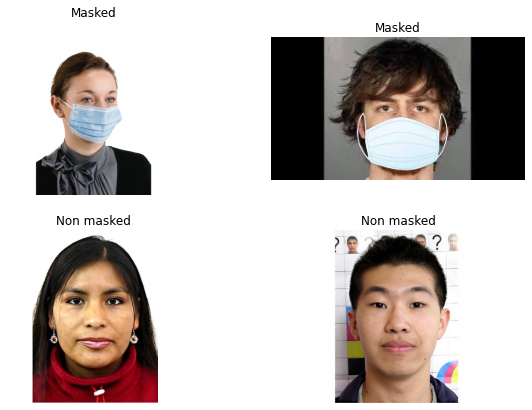

In [3]:
#import libraries
import cv2
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(10, 7)) # setting image size in output
rows,columns=2,2                  # defining number of rows and columns

# reading images
img1 = cv2.imread('drive/My Drive/datasets/mask/train/yes/007563.jpg')
img2 = cv2.imread('drive/My Drive/datasets/mask/train/yes/443-with-mask.jpg')
img3 = cv2.imread('drive/My Drive/datasets/mask/train/no/3.jpg')
img4 = cv2.imread('drive/My Drive/datasets/mask/train/no/40.jpg')
  
fig.add_subplot(rows, columns, 1) # Adds a subplot at the 1st position
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB));plt.axis('off');plt.title("Masked")
  
fig.add_subplot(rows, columns, 2) # Adds a subplot at the 2nd position
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB));plt.axis('off');plt.title("Masked")

fig.add_subplot(rows, columns, 3) # Adds a subplot at the 3rd position
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB));plt.axis('off');plt.title("Non masked")

fig.add_subplot(rows, columns, 4) # Adds a subplot at the 4th position
plt.imshow(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB));plt.axis('off');plt.title("Non masked")

#Reference: https://www.pyimagesearch.com/2014/11/03/display-matplotlib-rgb-image/,https://www.geeksforgeeks.org/how-to-display-multiple-images-in-one-figure-correctly-in-matplotlib/

##Part 2: Classification using transfer learning on pretrained classifiers

### Importing relevant libraries

In [14]:
# import the needed packages
import matplotlib.pyplot as plt
import matplotlib.image as img
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from scipy.stats.stats import pearsonr 
import matplotlib.cm as cm
from IPython.display import Image, display  
import tensorflow as tf
import seaborn as sn
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

### Defining ultility functions

Few utility function such as **dataGenerator** : to generate training and validation dataset, **plotHistrory** : to plot performance of model on train and validation set and **modelEvalute** : to calculate performance of model on test data using different parameters.

In [17]:
### Utility function to generate training and validation dataset from a provided dataset for a provided shape ###
def dataGenerator(shape,trainpath,classes,preprocessing,batch_size = 30): 
    imgdatagen = ImageDataGenerator(
        preprocessing_function = preprocessing,
        horizontal_flip = True,  # it has a 50% chance to flip left and right in the image.
        validation_split = 0.1,  # it keeps 90% of the images for training, reserving 10% of the images for validation.
        # rotation_range= 40,
        # zoom_range = 0.2,
        # shear_range = 0.2,
        # width_shift_range = 0.2,
        # height_shift_range =0.2
    )

    height, width = shape # defining height and width 

    # training dataset containing 90 percent of total data
    train_dataset = imgdatagen.flow_from_directory(
        trainpath,
        target_size = (height, width), 
        classes = (classes[0],classes[1]),
        batch_size = batch_size,
        subset = 'training', 
    )

    # validation dataset containing 10 percent of total data
    val_dataset = imgdatagen.flow_from_directory(
        trainpath,
        target_size = (height, width), 
        classes = (classes[0],classes[1]),
        batch_size = batch_size,
        subset = 'validation',
    )
    return train_dataset, val_dataset

### Utility function to plot performance of model wrt to epochs, ie plotting loss and accuracy as a function of epoch for training and validation dataset ###
def plotHistory(history):
    # Reference : https://www.kaggle.com/vasantvohra1/transfer-learning-using-mobilenet
    acc = history.history['acc']            # accuracy of model
    val_acc = history.history['val_acc']    # validation accuracy of model
    loss = history.history['loss']          # loss of model
    val_loss = history.history['val_loss']  # validation loss of model

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)                    # training performance wrt epoch
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)                  # validation performance wrt epoch
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,max(plt.ylim())])
    plt.title('Training and Validation Loss')
    plt.show()


### Utility function for Evaulation Metrics ###
def modelEvaluate(full_model,testpath,target_size=(224,224)):
    test_mask_imgs = os.listdir(testpath+'/yes')   # Testing directories for masked 
    test_no_mask_imgs = os.listdir(testpath+'/no') # Testing directories for non masked

    total_mask = len(test_mask_imgs)               # Numbers of images
    total_no_mask = len(test_no_mask_imgs)
    total = total_mask + total_no_mask

    # Confusion Matrix variables
    mask_correct = 0
    mask_incorrect = 0
    no_mask_correct = 0
    no_mask_incorrect = 0

    # Mask class
    for img in test_mask_imgs: 
        img_path = testpath+'/yes/'+ img
        img = image.load_img(img_path, target_size=target_size)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = keras.applications.vgg16.preprocess_input(x)
        ans = full_model.predict(x)
        if ans[0][0] > ans[0][1]:
            mask_correct += 1
        else:
            mask_incorrect += 1        
        # Mask recall
        mask_recall = mask_correct/total_mask

    # Non mask class
    for img in test_no_mask_imgs:
        img_path = testpath+'/no/'+ img
        img = image.load_img(img_path, target_size=target_size)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = keras.applications.vgg16.preprocess_input(x)
        ans = full_model.predict(x)
        if ans[0][1] > ans[0][0]:
            no_mask_correct += 1
        else:
            no_mask_incorrect += 1    
        # No-mask recall
        no_mask_recall = no_mask_correct/total_no_mask

    
    mask_precision = (mask_correct)/(mask_correct + mask_incorrect )                                      # Mask precision
    no_mask_precision = (no_mask_correct)/(no_mask_correct + no_mask_incorrect)                           # No-mask precision
    mask_f1 = 2 * ((mask_recall * mask_precision)/(mask_recall + mask_precision))                         # Mask F1 score
    no_mask_f1 = 2 * ((no_mask_recall * no_mask_precision)/(no_mask_recall + no_mask_precision))          # No-mask F1 score
    accuracy = (mask_correct + no_mask_correct)/total                                                     # Testing Classification accuracy
    recall = ((mask_recall*total_mask)+(no_mask_recall*total_no_mask))/(total_mask+total_no_mask)         # Weighted recall
    precision = ((mask_precision*total_mask)+(no_mask_precision*total_no_mask))/(total_mask+total_no_mask)# Weight precision
    f1 = 2 * ((recall * precision)/(recall + precision))# Weighted F1 score
    
    confusionmatrix = pd.DataFrame([[mask_correct,mask_incorrect],[no_mask_incorrect,no_mask_correct]],index = ["mask","nomask"],columns= ["mask","nomask"] ) # plotting confusion matrix
    plt.figure(figsize = (10,7)) # Reference : https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
    sn.heatmap(confusionmatrix, annot=True,fmt="d",annot_kws={"size": 30})

    return {'mask_precision':mask_precision,'no_mask_precision':no_mask_precision,
            'mask_f1':mask_f1,'no_mask_f1':no_mask_f1,
            'accuracy':accuracy,'recall':recall,'precision':precision,'f1':f1}

### Utility function to predict new image on trained model ###
def prediction(full_model,img_path,target_size=(224,224),actual="Mask"):
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = keras.applications.vgg16.preprocess_input(x)
    ans = full_model.predict(x)
    print("Model prediction output : ",ans)
    if ans[0][0] > ans[0][1]:
      label = "Mask"
    else:
      label = "Non mask"
    plt.title("Act:"+str(actual)+" Pred :"+str(label))
    plt.imshow(img)

### Model creation: VGG16


In [18]:
classes = ['yes','no']
TRAIN_PATH = 'drive/My Drive/datasets/mask/train'
train_dataset, val_dataset = dataGenerator((224,224),TRAIN_PATH,classes, preprocessing=keras.applications.vgg16.preprocess_input) # splitting dataset into train/validation set

Found 1086 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [19]:
# Model creation
base_model = keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3)) # base model : VGG16 we have used include_top = false to exclude the ending layers
x = keras.layers.Flatten()(base_model.output)                                                               # flatten the output of the convolutional part
x = keras.layers.Dense(128, activation='relu')(x)                                                           # creating a dense layer with 128 neurons
x = Dropout(0.4)(x)                                                                                         # to reduce overfitting
x = keras.layers.Dense(128, activation='relu')(x)                                                           # creating a dense layer with 128 neurons
predictions = keras.layers.Dense(2, activation='softmax')(x)                                                # final layer with 2 neurons representing probablities of masked and non masked class
full_model = Model(inputs=base_model.input, outputs=predictions)

# freeze layers of original old base model containing layers of VGG16 : This is concept of transfer learning where we are not changing weights of original pretrained model which usually gives better performance 
for layer in base_model.layers:
    layer.trainable = False

full_model.summary()# summary of full model  

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [20]:
# It's important to recompile your model after you make any changes to the `trainable`attribute of any inner layer, so that your changes are take into account
full_model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adamax(lr=0.001),
                  metrics=['acc']) # compiling full model with Adamax optimizer using accuracy as progression metric

history = full_model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    epochs=5,
)  # fitting training data to initiate learning

Epoch 1/5
37/37 [==============================] - 14s 320ms/step - loss: 1.5127 - acc: 0.8876 - val_loss: 0.2005 - val_acc: 0.9833
Epoch 2/5
37/37 [==============================] - 13s 310ms/step - loss: 0.0741 - acc: 0.9963 - val_loss: 0.0977 - val_acc: 0.9833
Epoch 3/5
37/37 [==============================] - 13s 312ms/step - loss: 0.0568 - acc: 0.9929 - val_loss: 0.0960 - val_acc: 0.9917
Epoch 4/5
37/37 [==============================] - 12s 307ms/step - loss: 0.0727 - acc: 0.9939 - val_loss: 0.1335 - val_acc: 0.9917
Epoch 5/5
37/37 [==============================] - 13s 305ms/step - loss: 0.0051 - acc: 0.9997 - val_loss: 0.0894 - val_acc: 0.9917


In [22]:
full_model.save_weights('vgg2model.h5')

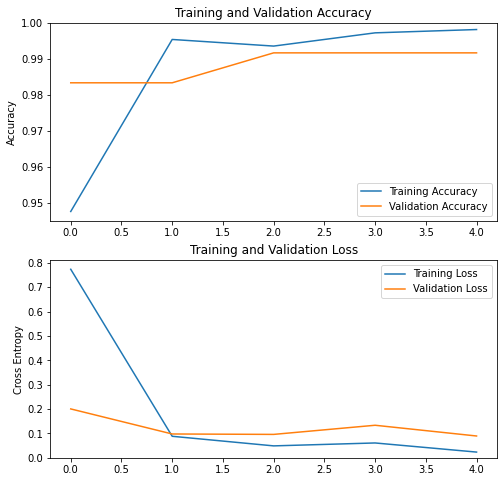

In [23]:
plotHistory(history) # plotting performance of model on training and validation dataset

{'accuracy': 0.9966887417218543,
 'f1': 0.9966887417218543,
 'mask_f1': 0.9933774834437086,
 'mask_precision': 0.9933774834437086,
 'no_mask_f1': 1.0,
 'no_mask_precision': 1.0,
 'precision': 0.9966887417218543,
 'recall': 0.9966887417218543}

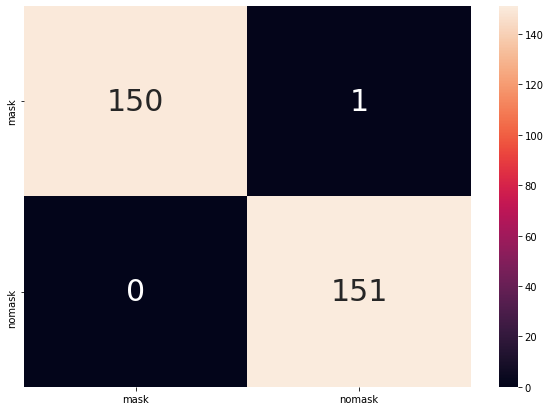

In [9]:
TEST_PATH = 'drive/My Drive/datasets/mask/test'
modelEvaluate(full_model,TEST_PATH) # performance of trained model on unseen held out data (test data)

**Results:** We have used VGG16 (Very Deep Convolutional Networks for Large Scale Image Recognition) architecture a base model from https://keras.io/api/applications/, adding extra layers of flattening then dense layers with droupout. It provides us with 99.6 testing accuracy which is quite efficient. We also testing without dropout layer, but dropout helped us reduce overfitting and thus improving performance on testing dataset.

**Choice of model:** We also tested with InceptionV3 base model, but VGG16 was performing much better as compared to Inceptionv3. Also we choice VGG16 because it has huge number of parameters as compared to other light models and thus was able to give us exceptional results. Alsoas there no restriction on resources and hardware, we selected heavy model otherwise a light weight model like MobileNet would have been a better choice.

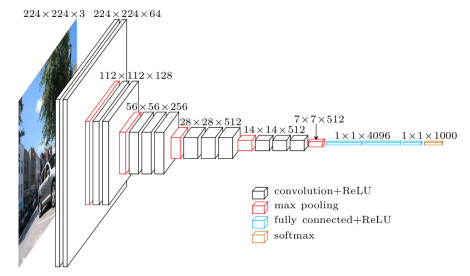

Fig. Architecture of VGG16

### Few outputs of predictive model on new data
The model will be now tested on new data(not even testing data) to analyze its actual performace in live environment.

**Model's output** : consists of 2 cells which represnts probablity of being masked and non masked. If probality of masked class is greater than non masked it is considered as masked image.

Model prediction output :  [[1.3583457e-21 1.0000000e+00]]


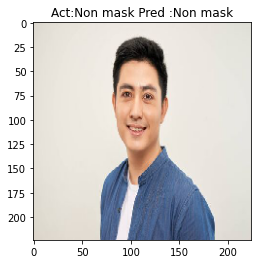

In [10]:
prediction(full_model,img_path = 'drive/My Drive/datasets/newsample/nonmask8.jpg',actual="Non mask")

Model prediction output :  [[1. 0.]]


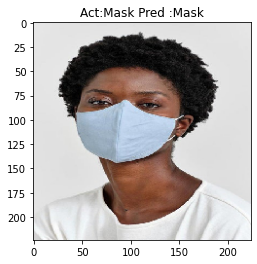

In [11]:
prediction(full_model,img_path = 'drive/My Drive/datasets/newsample/mask5.jpg',actual="Mask")

Model prediction output :  [[2.8568467e-27 1.0000000e+00]]


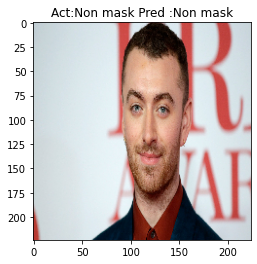

In [12]:
prediction(full_model,img_path = 'drive/My Drive/datasets/newsample/nonmask7.jpg',actual="Non mask")

Model prediction output :  [[1.0000000e+00 5.7220567e-36]]


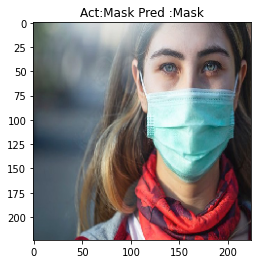

In [13]:
prediction(full_model,img_path = 'drive/My Drive/datasets/newsample/mask2.jpg',actual="Mask")

## Part 3: Investigating the base model (VGG16 model)

**Aim:** To identify one or more neurons whose
scalar output is strongly correlated with the class label of your dataset.

**Working procedure:**


*   Adding GlobalMaxPooling2D layer followed by Softmax layer just after the base model to anlyze its output.
*   We will consider the output of softmax layer which basically represents the scalar outputs of final layer of base model.

**We have approached this problem using two ways:**


*   Threshold based approach
*   Correlation based approach



Both aim to find neurons that can be treated as weak classifiers, whose output can be used to predict class label due to its high correlation.

### Creating new model with GlobalMaxPooling and Softmax layers:

The new model for this part's experiment is exactly same as befor with just two additional layer (GlobalMaxPolloing2D and Softmax) just after base model.


In [5]:
# base model : VGG16 we have used include_top = false to exclude the ending layers
base_model =  keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
x = keras.layers.GlobalMaxPool2D()(base_model.output)           # aggressively summarize the presence of a feature in an image
x = keras.layers.Softmax()(x)                                   # converts input to [0,1] range
x = keras.layers.Flatten()(x)                                   # flatten the output of the convolutional part
x = keras.layers.Dense(128, activation='relu')(x)               # creating a dense layer with 128 neurons
x = Dropout(0.4)(x)                                             # to reduce overfitting
x = keras.layers.Dense(128, activation='relu')(x)               # creating a dense layer with 128 neurons
predictions = keras.layers.Dense(2, activation='softmax')(x)    # final layer with 2 neurons representing probablities of masked and non masked class

full_model = Model(inputs=base_model.input, outputs=predictions)

# freeze layers of original old base model containing layers of VGG16
for layer in base_model.layers:
    layer.trainable = False

# summary of full model    
full_model.summary()

# Reference: https://keras.io/api/layers/pooling_layers/global_max_pooling2d/,https://keras.io/api/layers/activation_layers/softmax/

58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [6]:
# It's important to recompile your model after you make any changes to the `trainable` attribute of any inner layer, so that your changes are take into account
full_model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adamax(lr=0.001),
                  metrics=['acc'])# compiling full model with Adamax optimizer using accuracy as progression metric

history = full_model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    epochs=5,
)# fitting training data to initiate learning

Epoch 1/5
37/37 [==============================] - 154s 3s/step - loss: 0.6723 - acc: 0.7521 - val_loss: 0.6015 - val_acc: 0.9083
Epoch 2/5
37/37 [==============================] - 13s 306ms/step - loss: 0.5862 - acc: 0.8815 - val_loss: 0.4711 - val_acc: 0.9167
Epoch 3/5
37/37 [==============================] - 13s 312ms/step - loss: 0.4540 - acc: 0.9058 - val_loss: 0.3641 - val_acc: 0.9083
Epoch 4/5
37/37 [==============================] - 13s 313ms/step - loss: 0.3500 - acc: 0.9040 - val_loss: 0.3110 - val_acc: 0.8917
Epoch 5/5
37/37 [==============================] - 13s 311ms/step - loss: 0.2692 - acc: 0.9162 - val_loss: 0.2437 - val_acc: 0.9250


{'accuracy': 0.8874172185430463,
 'f1': 0.8874172185430463,
 'mask_f1': 0.7814569536423841,
 'mask_precision': 0.7814569536423841,
 'no_mask_f1': 0.9933774834437086,
 'no_mask_precision': 0.9933774834437086,
 'precision': 0.8874172185430463,
 'recall': 0.8874172185430463}

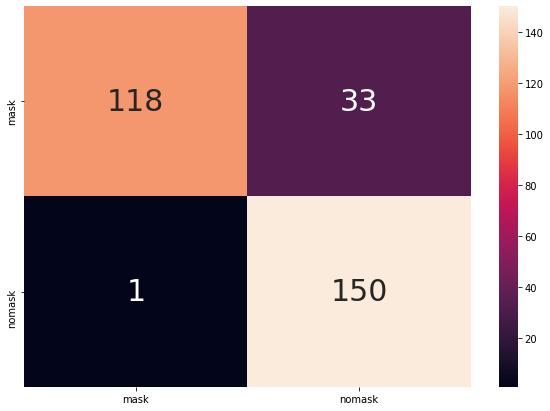

In [16]:
TEST_PATH = 'drive/My Drive/datasets/mask/test'
modelEvaluate(full_model,TEST_PATH) # performance of trained model on unseen held out data (test data)

We see that performance of our model decreased as compare to last model, that is because additional layer addded also lead to aggressive loose of data. Anyway those are important to anlayze the base model.

### Approach 1: Threshold based approach

We will use the outputs of softmax layer to find weak classifiers, which are strongley correlated to model's output. My approach for this section has been that after softmax layer, we will have nodes output between 0 to 1. 
We will provide two images for the two different classes and try to find nodes that give zero and non-zero outputs in sigmoid layer.
Finally the cells which give non zero results for first class and zero results for second class, can be regarded as weak classifier if they are seen in multiple test cases. Also viceversa exist, cells with zero results for first class and non zero for second.

In [17]:
layer_name = 'softmax'
layer = full_model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=base_model.input,outputs=layer.output) # to get softmax layers output which will be of shape (,512)

In [23]:
def findWeakClassifier(feature_extractor,imgwithmask,imgwithoutmask):
    img = image.load_img(imgwithmask, target_size=(224,224)) # image with mask
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = keras.applications.vgg16.preprocess_input(x)
    ans = full_model.predict(x)
    if ans[0][0] > ans[0][1]:
        ans = "Mask"
    else:
        ans = "Non mask"

    plt.subplot(2, 2, 1);plt.title("Act: Mask Pred :"+str(ans))
    plt.imshow(img) # visualising masked images
    x_features = feature_extractor(x)
    # finding nodes in sigmoid layer that presnt zero and non zero outputs for masked images
    c1_nonzero,c1_zero = [],[]
    for node_number,node in enumerate(x_features[0]):
        if node!=0:
            c1_nonzero.append(node_number)
        else:
            c1_zero.append(node_number)
            
    
    img = image.load_img(imgwithoutmask, target_size=(224,224)) # image without mask
    y = image.img_to_array(img)
    y = np.expand_dims(y, axis=0)
    y = keras.applications.vgg16.preprocess_input(y)
    ans = full_model.predict(y)
    if ans[0][0] > ans[0][1]:
        ans = "Mask"
    else:
        ans = "Non mask"
    plt.subplot(2, 2, 2);plt.title("Act: Non mask Pred :"+str(ans))
    plt.imshow(img) # visualising non-masked images
    y_features = feature_extractor(y)
    # finding nodes in sigmoid layer that presnt zero and non zero outputs for non masked images
    c2_nonzero,c2_zero = [],[]
    for node_number,node in enumerate(y_features[0]):
        if node!=0:
            c2_nonzero.append(node_number)
        else:
            c2_zero.append(node_number)
    # intersection of list of nodes that give zero output for mask and list of nodes that give non zero output for  non mask can be considered as candidates for weak classifiers and vice versa            
    return {"maskedzero":list(set(c1_zero) & set(c2_nonzero)),"maskednonzero":list(set(c2_zero) & set(c1_nonzero)),"correlation":pearsonr(x_features[0],y_features[0])}

{'correlation': (-0.001958590568045414, 0.9647373551158505),
 'maskednonzero': [97, 243],
 'maskedzero': [193,
  131,
  387,
  389,
  230,
  265,
  10,
  462,
  79,
  47,
  402,
  437,
  374,
  407,
  314,
  220,
  317,
  286]}

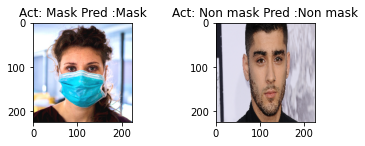

In [24]:
# Here we have experimented on a set of masked and non masked image
findWeakClassifier(feature_extractor,'drive/My Drive/datasets/newsample/mask4.jpg','drive/My Drive/datasets/newsample/nonmask4.jpg') # first  image will belong to masked class and second nonmasked class

{'correlation': (-0.0019569471624266105, 0.9647669239513273),
 'maskednonzero': [243],
 'maskedzero': [144]}

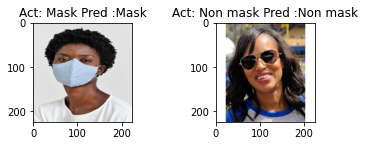

In [20]:
findWeakClassifier(feature_extractor,'drive/My Drive/datasets/newsample/mask5.jpg','drive/My Drive/datasets/newsample/nonmask5.jpg')

{'correlation': (-0.001956947162745199, 0.9647669239456312),
 'maskednonzero': [243],
 'maskedzero': [389,
  390,
  397,
  407,
  152,
  411,
  413,
  436,
  56,
  193,
  79,
  473,
  220,
  224,
  486,
  105,
  363,
  506,
  509]}

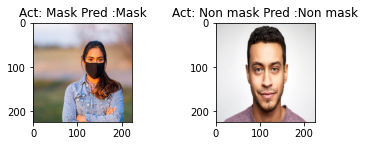

In [21]:
findWeakClassifier(feature_extractor,'drive/My Drive/datasets/newsample/mask6.jpg','drive/My Drive/datasets/newsample/nonmask6.jpg')

{'correlation': (-0.002112495900893295, 0.9619684463595407),
 'maskednonzero': [97, 243],
 'maskedzero': [480, 389, 10, 107, 242, 306, 377, 314, 411, 220]}

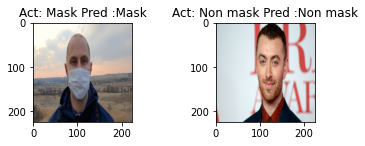

In [22]:
findWeakClassifier(feature_extractor,'drive/My Drive/datasets/newsample/mask7.jpg','drive/My Drive/datasets/newsample/nonmask7.jpg')

The above experiments shows that the cells **97** and **243** helps almost every time to classify the image into two classes. So these can be treated as weak classifers where **243 node is a really good weak classifier**.


### Approach 2: Correlation based approach

In this apprach we are going to use a set of masked images and try to find nodes which give some correlation between the sigmoid's layer output and the actual class label.

In [27]:
maskedImages = ['drive/My Drive/datasets/newsample/mask3.jpg','drive/My Drive/datasets/newsample/mask4.jpg',
                'drive/My Drive/datasets/newsample/mask5.jpg','drive/My Drive/datasets/newsample/mask6.jpg',
                'drive/My Drive/datasets/newsample/mask7.jpg'] # Considering set of five masked images as to find corealation we need to have more than one instances

nodesvalues = []
outputs = []
for img_path in maskedImages:
    original_img = cv2.imread(img_path, 1)
    img = image.load_img(img_path, target_size=(224,224))
    y = image.img_to_array(img)
    y = np.expand_dims(y, axis=0)
    y = keras.applications.vgg16.preprocess_input(y)
    ans = full_model.predict(y)                         # predicted class by model
    y_features = feature_extractor(y)                   # output of sigmoid layer when same image is passed
    x = tf.Variable(y_features[0]).numpy().tolist()     # converting to python list
    nodesvalues.append(x)                               # appending to nodevalues to create a matrix 
    outputs.append(ans[0])

df = pd.DataFrame(nodesvalues)   
output_df = pd.DataFrame(outputs) 

In [39]:
print(df.shape)
print(output_df.shape)

(5, 512)
(5, 2)


In [32]:
mapper = {}                                                # map to store node number to the coerralation
for i in range(512):
    coerr = pearsonr(df[i].tolist(),output_df[0].tolist()) # correlation between a list of output of node 'i' of sigmoid layer to the output probablity of being masked
    mapper[i] = coerr[0]

print(mapper) # most coerrelation will be nan, as calculation with zero vectors in denominator of coerrelation formula is non defined

{0: nan, 1: nan, 2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan, 8: nan, 9: nan, 10: nan, 11: nan, 12: nan, 13: nan, 14: nan, 15: nan, 16: nan, 17: nan, 18: nan, 19: nan, 20: nan, 21: nan, 22: nan, 23: nan, 24: nan, 25: nan, 26: nan, 27: nan, 28: nan, 29: nan, 30: nan, 31: nan, 32: nan, 33: nan, 34: nan, 35: nan, 36: nan, 37: nan, 38: nan, 39: nan, 40: nan, 41: nan, 42: nan, 43: nan, 44: nan, 45: nan, 46: nan, 47: nan, 48: nan, 49: nan, 50: nan, 51: nan, 52: nan, 53: nan, 54: nan, 55: nan, 56: nan, 57: nan, 58: nan, 59: nan, 60: nan, 61: nan, 62: nan, 63: nan, 64: nan, 65: nan, 66: nan, 67: nan, 68: nan, 69: nan, 70: nan, 71: nan, 72: nan, 73: nan, 74: nan, 75: nan, 76: nan, 77: nan, 78: nan, 79: nan, 80: nan, 81: nan, 82: nan, 83: nan, 84: nan, 85: nan, 86: nan, 87: nan, 88: nan, 89: nan, 90: nan, 91: nan, 92: nan, 93: nan, 94: nan, 95: nan, 96: nan, 97: 1.0, 98: nan, 99: nan, 100: nan, 101: nan, 102: nan, 103: nan, 104: nan, 105: nan, 106: nan, 107: nan, 108: nan, 109: nan, 110: nan,

In [34]:
# Only node number 243 and 97 give correlation between the actual outputs and their results
print("Correlation between ouputs of node 243 of sigmoid layer and actual model output :",mapper[243])
print("Correlation between ouputs of node 97 of sigmoid layer and actual model output :",mapper[97])

Correlation between ouputs of node 243 of sigmoid layer and actual model output : -1.0
Correlation between ouputs of node 97 of sigmoid layer and actual model output : 1.0


This shows that cell **97** and **243** can be treated as weak classifers as there is a correlation between their outputs and actual output class for any image. Also we could have used the globalmaxpooling layer's output to find its output correlation with actual class, but then there we would have to sort the correaltions to find nodes with highest significance.

## Part 4: Object localisation 

Usig the neurons identified in part 3, we will try to build a object localisation system. For part 3 , we found nodes 97 and 243 can be treated as weak classifier. For this part we will consider **node 243** and try to projects its output on the original image.

In [12]:
full_model.summary() # summary of full model    

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

We will find the output of last layer of base model corresponding to 243th node and finally superimpose it on the actual image which will help us find mask objects in the image.

In [8]:
layer_name ='block5_pool' # last layer of base model, just before the globalmaxpooling2d layer
layer = full_model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=base_model.input,outputs=layer.output) # the output for this layer will 512 matrix of shape 7*7

In [9]:
### Utility function to generate output of last layer of base model corresponding to node 243 for any image provided ###
def generateHeatMap(img_path,feature_extractor=feature_extractor,display=False):
  img = image.load_img(img_path, target_size=(224,224))
  if display==True:
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.imshow(img)                                 # plot original image
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = keras.applications.vgg16.preprocess_input(x)
  heatmap = feature_extractor.predict(x)[0,:,:,243] # only consider output related to node 243
  print("Shape of heatmap/output of last layer of base model : ",heatmap.shape)
  if display==True:
    plt.subplot(2, 1, 2)
    plt.imshow(heatmap)                             #plot heatmap/visual output of last layer of base model
  return heatmap

Shape of heatmap/output of last layer of base model :  (7, 7)


array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 2.5710314e+01, 5.3908810e+01, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 2.2020973e+02, 3.6703250e+02, 3.3228778e+02,
        2.4470311e+02, 7.8070885e+01, 0.0000000e+00],
       [0.0000000e+00, 1.8764856e+02, 2.5347183e+02, 2.6600748e+02,
        2.1730624e+02, 5.2938187e+01, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 2.6528315e+01, 1.7652683e-01,
        2.0523712e+01, 1.1765521e+01, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 5.2243409e+00, 1.6341351e+01,
        1.0226206e+01, 0.0000000e+00, 0.0000000e+00]], dtype=float32)

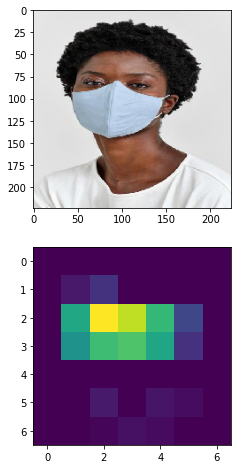

In [10]:
generateHeatMap('drive/My Drive/datasets/newsample/mask5.jpg',display=True) # heatmap for mask class input, we can observe it represnts teh mask using differnet colors

Shape of heatmap/output of last layer of base model :  (7, 7)


array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

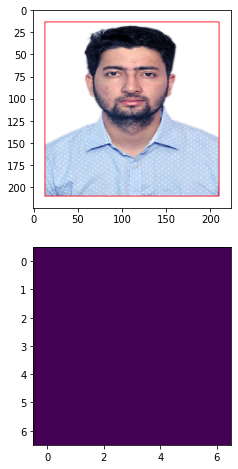

In [12]:
generateHeatMap('drive/My Drive/datasets/newsample/nonmask2.JPG',display=True) # heatmap for non mask class input, as there is no mask the output is plain matrix

Shape of heatmap/output of last layer of base model :  (7, 7)


array([[  0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ],
       [  0.       ,   0.       ,  24.066097 ,  74.190994 ,  10.208179 ,
          0.       ,   0.       ],
       [  0.       , 109.90827  , 348.4325   , 403.77463  , 350.3831   ,
         95.15318  ,   0.       ],
       [  0.       ,  55.1174   , 219.52582  , 248.34329  , 226.05464  ,
          7.1462107,   0.       ],
       [  0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
          0.       ,   0.       ]], dtype=float32)

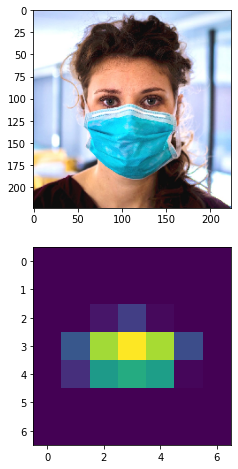

In [13]:
generateHeatMap('drive/My Drive/datasets/newsample/mask4.jpg',display=True) # heatmap for mask class input, we can observe it represnts teh mask using differnet colors

Finally we will use a function to superimpose the base model's output on actual image to get a sense of object localisation.

In [15]:
# Reference : https://keras.io/examples/vision/grad_cam/ (This code is taken and modified a little using code of keras website)
### Utility function to superimpose base models heatmap output on actual image ###
def superimposeHeatMap(img_path,alpha=0.8,cam_path="cam.jpg"):
  heatmap = generateHeatMap(img_path)                   # generate heatmap using utility function
  img = keras.preprocessing.image.load_img(img_path)
  img = keras.preprocessing.image.img_to_array(img)

  heatmap = np.uint8(255 * heatmap)                     # Rescale heatmap to a range 0-255
  jet = cm.get_cmap("jet")                              # Use jet colormap to colorize heatmap

  # Use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  # Create an image with RGB colorized heatmap
  jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

  superimposed_img = jet_heatmap * alpha + img            # Superimpose the heatmap on original image
  superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
  superimposed_img = superimposed_img.resize((300,300))   # fix size of output superimposed image
  superimposed_img.save(cam_path)                         # Save the superimposed image
  display(Image(cam_path))                                # Display Grad CAM


Shape of heatmap/output of last layer of base model :  (7, 7)


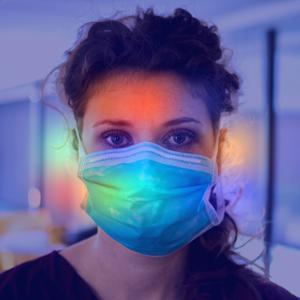

In [16]:
superimposeHeatMap('drive/My Drive/datasets/newsample/mask4.jpg') # we can sense that our object localising system tries to find mask in the image

Shape of heatmap/output of last layer of base model :  (7, 7)


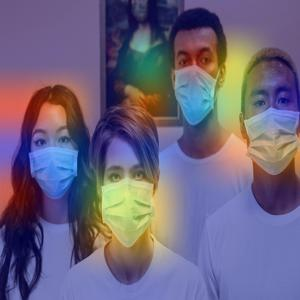

In [52]:
superimposeHeatMap('drive/My Drive/datasets/newsample/groupmask.jpg') # output of image with multiple people with mask, works really well finding people with mask

Shape of heatmap/output of last layer of base model :  (7, 7)


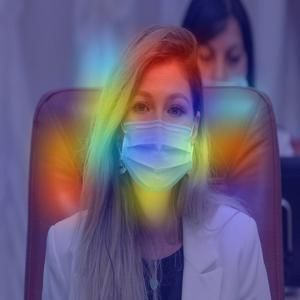

In [57]:
superimposeHeatMap('drive/My Drive/datasets/newsample/mask8.jpg')

Shape of heatmap/output of last layer of base model :  (7, 7)


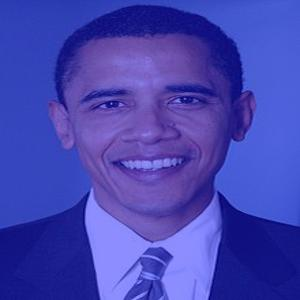

In [58]:
superimposeHeatMap('drive/My Drive/datasets/newsample/nonmask1.jpg') # image with no mask

Shape of heatmap/output of last layer of base model :  (7, 7)


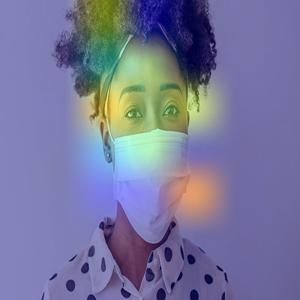

In [61]:
superimposeHeatMap('drive/My Drive/datasets/newsample/mask1.jpg')